## 3D classification
https://github.com/Project-MONAI/tutorials/blob/main/3d_classification/densenet_training_array.ipynb

In [ ]:
!nvidia-smi

Thu Jun  1 14:39:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |  28879MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/ori/'
# save_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/classifier/results/TCIA/BCLC/joint fusion/'
save_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/classifier/results/TCIA/TNM/joint fusion/'

image_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/'

mask_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/'

clinical_data_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/ori/HCC-TACE-Seg_clinical_data-V2.xlsx'

excel_path = '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/classifier/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## load pretrain model

## Setup imports

In [ ]:
import pandas as pd
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import nibabel as nib

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset, pad_list_data_collate, CacheDataset, TestTimeAugmentation
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    RandRotate90d,
    Resized,
    EnsureTyped,
    CropForegroundd,
    CenterSpatialCropd,
    RandAffined,
    RandGaussianNoised,
    ToTensord,
    LoadImaged,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    MaskIntensityd,
    NormalizeIntensityd,
    ScaleIntensityd
)

In [ ]:
# set the device we will be using to train the model
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.1.0
Numpy version: 1.22.4
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.2
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Hyperparameters

In [ ]:
# define training hyperparameters
BS = 6
pin_memory = True
num_classes = 3 #3  #4
max_epochs = 100#100
val_interval = 1#2
best_metric = -1
best_metric_epoch = -1
LR = 1e-5
num_worker = 0#2

## shuffle data

In [ ]:
# train_data = pd.read_excel(excel_path + "all_data.xlsx", sheet_name='TNM') #'train'+str(fold)
# ID = train_data['TCIA_ID'].values
# label = train_data['label'].values

In [ ]:
# # split data
# split = int(0.6 * len(ID)) #the training split casted into int for numeric rounding
# test_split = int(0.8 * len(ID))#the test split #0.9
# print(ID)
# np.random.seed(42)
# # shuffles the data
# state = np.random.get_state()
# np.random.shuffle(ID)

# print("state =",state)

# print(label)
# np.random.set_state(state)
# np.random.shuffle(label)
# np.random.set_state(state)
# print("------")
# print(ID)
# print(label)

In [ ]:
# # count label
# import collections

# train_LB = label[:split]
# val_LB = label[split:test_split]
# test_LB = label[test_split:]

# print("train_LB :",len(train_LB))
# print(collections.Counter(train_LB))
# print("------------------------")
# print("val_LB :",len(val_LB))
# print(collections.Counter(val_LB))
# print("------------------------")
# print("test_LB :",len(test_LB))
# print(collections.Counter(test_LB))

# read excel data

In [ ]:
fold = 1
train_data = pd.read_excel(excel_path + "train.xlsx", sheet_name='train'+str(fold))
# train_data = pd.read_excel(excel_path + "train_TNM.xlsx", sheet_name='fold'+str(fold))
ID = train_data['image'].values

train_lab = train_data['label'].values
train_img_pre = []
train_mask_pre = []

train_img_A = []
train_mask_A = []

train_img_PV = []
train_mask_PV = []

for i in range(len(ID)):
  img_pre_path = image_path+ID[i]+"_pre.nii.gz"
  train_img_pre.append(img_pre_path)
  pre_path = mask_path+ID[i]+"_pre.nii.gz"
  train_mask_pre.append(pre_path)

  img_A_path = image_path+ID[i]+"_A.nii.gz"
  train_img_A.append(img_A_path)
  A_path = mask_path+ID[i]+"_A.nii.gz"
  train_mask_A.append(A_path)

  img_PV_path = image_path+ID[i]+"_PV.nii.gz"
  train_img_PV.append(img_PV_path)
  PV_path = mask_path+ID[i]+"_PV.nii.gz"
  train_mask_PV.append(PV_path)

train_files = [{"PREimg": PRE_img_name, "Aimg": A_img_name, "PVimg": PV_img_name, "lab": label_name, "PREmask": PRE_mask_name, "Amask": A_mask_name, "PVmask": PV_mask_name}
                   for PRE_img_name, A_img_name, PV_img_name, label_name, PRE_mask_name, A_mask_name, PV_mask_name
              in zip(train_img_pre, train_img_A, train_img_PV, train_lab, train_mask_pre, train_mask_A, train_mask_PV)]

display(train_files)

[{'PREimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_027_pre.nii.gz',
  'Aimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_027_A.nii.gz',
  'PVimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_027_PV.nii.gz',
  'lab': 0,
  'PREmask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_027_pre.nii.gz',
  'Amask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_027_A.nii.gz',
  'PVmask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_027_PV.nii.gz'},
 {'PREimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_079_pre.nii.gz',
  'Aimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_079_A.nii.gz',
  'PVimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_079_PV.nii.gz',
  'lab': 0,
  'PREmask': '/content/driv

In [ ]:
val_data = pd.read_excel(excel_path + "val_TNM.xlsx", sheet_name='fold'+str(fold))#'val'+str(fold) #'TNM'
ID = val_data['image'].values
val_lab = val_data['label'].values
val_img_pre = []
val_mask_pre = []

val_img_A = []
val_mask_A = []

val_img_PV = []
val_mask_PV = []

for i in range(len(ID)):
  img_pre_path = image_path+ID[i]+"_pre.nii.gz"
  val_img_pre.append(img_pre_path)
  pre_path = mask_path+ID[i]+"_pre.nii.gz"
  val_mask_pre.append(pre_path)

  img_A_path = image_path+ID[i]+"_A.nii.gz"
  val_img_A.append(img_A_path)
  A_path = mask_path+ID[i]+"_A.nii.gz"
  val_mask_A.append(A_path)

  img_PV_path = image_path+ID[i]+"_PV.nii.gz"
  val_img_PV.append(img_PV_path)
  PV_path = mask_path+ID[i]+"_PV.nii.gz"
  val_mask_PV.append(PV_path)

val_files = [{"PREimg": PRE_img_name, "Aimg": A_img_name, "PVimg": PV_img_name, "lab": label_name, "PREmask": PRE_mask_name, "Amask": A_mask_name, "PVmask": PV_mask_name}
                   for PRE_img_name, A_img_name, PV_img_name, label_name, PRE_mask_name, A_mask_name, PV_mask_name
              in zip(val_img_pre, val_img_A, val_img_PV, val_lab, val_mask_pre, val_mask_A, val_mask_PV)]

display(val_files)

[{'PREimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_013_pre.nii.gz',
  'Aimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_013_A.nii.gz',
  'PVimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_013_PV.nii.gz',
  'lab': 2,
  'PREmask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_013_pre.nii.gz',
  'Amask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_013_A.nii.gz',
  'PVmask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_013_PV.nii.gz'},
 {'PREimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_066_pre.nii.gz',
  'Aimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_066_A.nii.gz',
  'PVimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_066_PV.nii.gz',
  'lab': 0,
  'PREmask': '/content/driv

In [ ]:
test_data = pd.read_excel(excel_path + "test_TNM.xlsx", sheet_name='test') #'train'+str(fold)#'TNM'
ID = test_data['image'].values

test_lab = test_data['label'].values
test_img_pre = []
test_mask_pre = []

test_img_A = []
test_mask_A = []

test_img_PV = []
test_mask_PV = []

for i in range(len(ID)):
  img_pre_path = image_path+ID[i]+"_pre.nii.gz"
  test_img_pre.append(img_pre_path)
  pre_path = mask_path+ID[i]+"_pre.nii.gz"
  test_mask_pre.append(pre_path)

  img_A_path = image_path+ID[i]+"_A.nii.gz"
  test_img_A.append(img_A_path)
  A_path = mask_path+ID[i]+"_A.nii.gz"
  test_mask_A.append(A_path)

  img_PV_path = image_path+ID[i]+"_PV.nii.gz"
  test_img_PV.append(img_PV_path)
  PV_path = mask_path+ID[i]+"_PV.nii.gz"
  test_mask_PV.append(PV_path)

test_files = [{"PREimg": PRE_img_name, "Aimg": A_img_name, "PVimg": PV_img_name, "lab": label_name, "PREmask": PRE_mask_name, "Amask": A_mask_name, "PVmask": PV_mask_name}
                   for PRE_img_name, A_img_name, PV_img_name, label_name, PRE_mask_name, A_mask_name, PV_mask_name
              in zip(test_img_pre, test_img_A, test_img_PV, test_lab, test_mask_pre, test_mask_A, test_mask_PV)]
display(test_files)

[{'PREimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_004_pre.nii.gz',
  'Aimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_004_A.nii.gz',
  'PVimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_004_PV.nii.gz',
  'lab': 2,
  'PREmask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_004_pre.nii.gz',
  'Amask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_004_A.nii.gz',
  'PVmask': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/segmentation/results_phase/HCC_004_PV.nii.gz'},
 {'PREimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_060_pre.nii.gz',
  'Aimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_060_A.nii.gz',
  'PVimg': '/content/drive/MyDrive/Colab_Notebooks/liver_cancer/data/TCIA/[image]/HCC_060_PV.nii.gz',
  'lab': 0,
  'PREmask': '/content/driv

# CacheDataset

In [ ]:
# Define transforms
spatial_size = (300,300,300)

#scaleintensityrange 0-1 or -1-1
#scaleintensity
train_transforms = Compose([
    LoadImaged(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"]),
    EnsureChannelFirstd(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"]),
    Spacingd(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"], pixdim=(1,1,1)),
    # CropForegroundd(keys=["img"], source_key="img", select_fn = lambda x: x>-135, margin=100),
    Orientationd(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"], axcodes="RAS"),
    CropForegroundd(keys=["PREimg","PREmask"], source_key="PREmask", margin=30),#, select_fn = lambda x: x>1
    CropForegroundd(keys=["Aimg","Amask"], source_key="Amask", margin=30),
    CropForegroundd(keys=["PVimg","PVmask"], source_key="PVmask", margin=30),
    # CenterSpatialCropd(keys=["img","mask"], roi_size=spatial_size),
    ScaleIntensityRanged(keys=["PREimg","Aimg","PVimg"], a_min=-135, a_max=215, b_min=0.0, b_max=1.0),
    Resized(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"], spatial_size=(96, 96, 96), mode=['area','area','area','nearest','nearest','nearest']),
    # RandAffined(keys=["img"]),
    RandGaussianNoised(keys=["PREimg","Aimg","PVimg"]),
    RandRotate90d(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"]),
    # Three2TwoDimd(keys=["img", "lab", "mask"]), ##
    NormalizeIntensityd(keys=["PREimg","Aimg","PVimg"]),
    ScaleIntensityd(keys=["PREimg","Aimg","PVimg"]),
    ToTensord(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask","lab"])
    ])


val_transforms = Compose([
    LoadImaged(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"]),
    EnsureChannelFirstd(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"]),
    Spacingd(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"], pixdim=(1,1,1)),
    # CropForegroundd(keys=["img"], source_key="img", select_fn = lambda x: x>-135, margin=100),
    Orientationd(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"], axcodes="RAS"),
    CropForegroundd(keys=["PREimg","PREmask"], source_key="PREmask", margin=30),#, select_fn = lambda x: x>1
    CropForegroundd(keys=["Aimg","Amask"], source_key="Amask", margin=30),
    CropForegroundd(keys=["PVimg","PVmask"], source_key="PVmask", margin=30),
    # CenterSpatialCropd(keys=["img","mask"], roi_size=spatial_size),
    ScaleIntensityRanged(keys=["PREimg","Aimg","PVimg"], a_min=-135, a_max=215, b_min=0.0, b_max=1.0),
    Resized(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask"], spatial_size=(96, 96, 96), mode=['area','area','area','nearest','nearest','nearest']),
    # Three2TwoDimd(keys=["img", "lab", "mask"]), ##
    NormalizeIntensityd(keys=["PREimg","Aimg","PVimg"]),
    ScaleIntensityd(keys=["PREimg","Aimg","PVimg"]),
    ToTensord(keys=["PREimg","Aimg","PVimg","PREmask","Amask","PVmask","lab"])
    ])

## check_loader

In [ ]:
# check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, num_workers=1, prefetch_factor=1, collate_fn=pad_list_data_collate)

In [ ]:
# # check data shape
# i = 1
# for check_data in check_loader:
#     if i == 1:
#         img_tmp, mask_tmp = (check_data["PREimg"], check_data["PREmask"])
#         print(f"img shape: {img_tmp.shape}, img_resize shape: {mask_tmp.shape}")
#         break
#     #i = i + 1

In [ ]:
# check_data = monai.utils.first(check_loader)
# print(check_data["PREimg"].shape)
# img_tmp, mask_tmp, label_tmp = (check_data["PREimg"][0,0,:,:,:], check_data["PREmask"][0,0,:,:,:], check_data["lab"])
# print(f"img shape: {img_tmp.shape}, mask shape: {mask_tmp.shape}, label shape: {label_tmp.shape}")
# plt.figure("check", (20, 60))
# for i in range(img_tmp.shape[0]):
#     plt.subplot(32, 6, i+1)
#     plt.title(f"label: {label_tmp[0]}")
#     plt.imshow(img_tmp[:, :,i], cmap="gray",)
#     plt.subplot(32, 6, 96+1+i)
#     plt.title("mask")
#     plt.imshow(mask_tmp[:, :,i], cmap="gray", vmax=1)
# plt.show()

# PyTorch Balanced Sampler function
https://github.com/khornlund/pytorch-balanced-sampler
https://github.com/ufoym/imbalanced-dataset-sampler

In [ ]:
class_lab = []
class_idxs = []
class_idxs_0 = []
class_idxs_1 = []
class_idxs_2 = []

for i in range(len(train_files)):
  classes = train_files[i]["lab"]
  class_lab.append(classes)
  if classes == 0:
    class_idxs_0.append(i)
  elif classes == 1:
    class_idxs_1.append(i)
  elif classes == 2:
    class_idxs_2.append(i)
class_idxs.append(class_idxs_0)
class_idxs.append(class_idxs_1)
class_idxs.append(class_idxs_2)
print(class_lab)
print(class_idxs)

[0, 0, 2, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 0, 2]
[[0, 1, 4, 6, 10, 18, 19, 22, 23, 24, 28, 30, 32, 33, 34, 39, 40, 45, 46, 49], [3, 7, 8, 9, 13, 14, 20, 27, 29, 31, 37, 38, 42, 44], [2, 5, 11, 12, 15, 16, 17, 21, 25, 26, 35, 36, 41, 43, 47, 48, 50]]


[20 14 17]
51
[0.39215686 0.2745098  0.33333333]


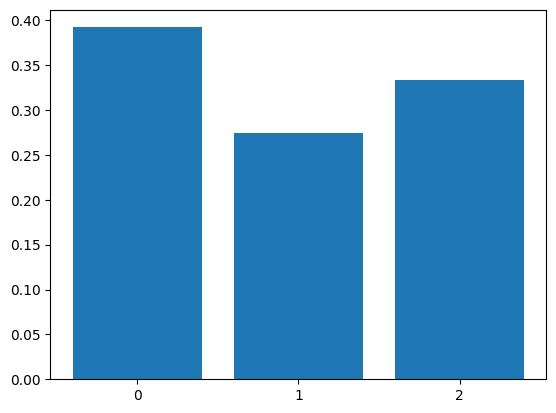

In [ ]:
fig, ax = plt.subplots()
classe_labels, counts = np.unique(class_lab, return_counts=True)
print(counts)
print(sum(counts))
proportion = counts[:]/sum(counts)
print(proportion)
ax.bar(classe_labels, proportion)
ax.set_xticks(classe_labels)
plt.show()

In [ ]:
import logging
import logging.config


logging_level_dict = {
    0: logging.WARNING,
    1: logging.INFO,
    2: logging.DEBUG
}


DEFAULT_CONFIG = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'simple': {
            'format': "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        }
    },
    'handlers': {
        'console': {
            'class': 'logging.StreamHandler',
            'level': 'DEBUG',
            'formatter': 'simple',
            'stream': 'ext://sys.stdout'
        }
    }
}


def setup_logging(config=DEFAULT_CONFIG):
    """Setup logging configuration"""
    logging.config.dictConfig(config)


def setup_logger(cls, name='', verbose=0):
    logger = logging.getLogger(name)
    if verbose not in logging_level_dict:
        raise KeyError(f'Verbose option {verbose} for {name} not valid. '
                        'Valid options are {logging_level_dict.keys()}.')
    logger.setLevel(logging_level_dict[verbose])
    return logger


setup_logging()

In [ ]:
import numpy as np
from torch.utils.data.sampler import BatchSampler, WeightedRandomSampler


class SamplerFactory:
    """
    Factory class to create balanced samplers.
    """

    def __init__(self, verbose=0):
        self.logger = setup_logger(self.__class__.__name__, verbose)

    def get(self, class_idxs, batch_size, n_batches, alpha, kind):
        """
        Parameters
        ----------
        class_idxs : 2D list of ints
            List of sample indices for each class. Eg. [[0, 1], [2, 3]] implies indices 0, 1
            belong to class 0, and indices 2, 3 belong to class 1.
        batch_size : int
            The batch size to use.
        n_batches : int
            The number of batches per epoch.
        alpha : numeric in range [0, 1]
            Weighting term used to determine weights of each class in each batch.
            When `alpha` == 0, the batch class distribution will approximate the training population
            class distribution.
            When `alpha` == 1, the batch class distribution will approximate a uniform distribution,
            with equal number of samples from each class.
        kind : str ['fixed' | 'random']
            The kind of sampler. `Fixed` will ensure each batch contains a constant proportion of
            samples from each class. `Random` will simply sample with replacement according to the
            calculated weights.
        """
        if kind == 'random':
            return self.random(class_idxs, batch_size, n_batches, alpha)
        if kind == 'fixed':
            return self.fixed(class_idxs, batch_size, n_batches, alpha)
        raise Exception(f'Received kind {kind}, must be `random` or `fixed`')

    def random(self, class_idxs, batch_size, n_batches, alpha):
        self.logger.info(f'Creating `{WeightedRandomBatchSampler.__class__.__name__}`...')
        class_sizes, weights = self._weight_classes(class_idxs, alpha)
        sample_rates = self._sample_rates(weights, class_sizes)
        return WeightedRandomBatchSampler(sample_rates, class_idxs, batch_size, n_batches)

    def fixed(self, class_idxs, batch_size, n_batches, alpha):
        self.logger.info(f'Creating `{WeightedFixedBatchSampler.__class__.__name__}`...')
        class_sizes, weights = self._weight_classes(class_idxs, alpha)
        class_samples_per_batch = self._fix_batches(weights, class_sizes, batch_size, n_batches)
        return WeightedFixedBatchSampler(class_samples_per_batch, class_idxs, n_batches)

    def _weight_classes(self, class_idxs, alpha):
        class_sizes = np.asarray([len(idxs) for idxs in class_idxs])
        n_samples = class_sizes.sum()
        n_classes = len(class_idxs)

        original_weights = np.asarray([size / n_samples for size in class_sizes])
        uniform_weights = np.repeat(1 / n_classes, n_classes)

        self.logger.info(f'Sample population absolute class sizes: {class_sizes}')
        self.logger.info(f'Sample population relative class sizes: {original_weights}')

        weights = self._balance_weights(uniform_weights, original_weights, alpha)
        return class_sizes, weights

    def _balance_weights(self, weight_a, weight_b, alpha):
        assert alpha >= 0 and alpha <= 1, f'invalid alpha {alpha}, must be 0 <= alpha <= 1'
        beta = 1 - alpha
        weights = (alpha * weight_a) + (beta * weight_b)
        self.logger.info(f'Target batch class distribution {weights} using alpha={alpha}')
        return weights

    def _sample_rates(self, weights, class_sizes):
        return weights / class_sizes

    def _fix_batches(self, weights, class_sizes, batch_size, n_batches):
        """
        Calculates the number of samples of each class to include in each batch, and the number
        of batches required to use all the data in an epoch.
        """
        class_samples_per_batch = np.round((weights * batch_size)).astype(int)

        # cleanup rounding edge-cases
        remainder = batch_size - class_samples_per_batch.sum()
        largest_class = np.argmax(class_samples_per_batch)
        class_samples_per_batch[largest_class] += remainder

        assert class_samples_per_batch.sum() == batch_size

        proportions_of_class_per_batch = class_samples_per_batch / batch_size
        self.logger.info(f'Rounded batch class distribution {proportions_of_class_per_batch}')

        proportions_of_samples_per_batch = class_samples_per_batch / class_sizes

        self.logger.info(f'Expecting {class_samples_per_batch} samples of each class per batch, '
                         f'over {n_batches} batches of size {batch_size}')

        oversample_rates = proportions_of_samples_per_batch * n_batches
        self.logger.info(f'Sampling rates: {oversample_rates}')

        return class_samples_per_batch


class WeightedRandomBatchSampler(BatchSampler):
    """
    Samples with replacement according to the provided weights.
    Parameters
    ----------
    class_weights : `numpy.array(int)`
        The number of samples of each class to include in each batch.
    class_idxs : 2D list of ints
        The indices that correspond to samples of each class.
    batch_size : int
        The size of each batch yielded.
    n_batches : int
        The number of batches to yield.
    """

    def __init__(self, class_weights, class_idxs, batch_size, n_batches):
        self.sample_idxs = []
        for idxs in class_idxs:
            self.sample_idxs.extend(idxs)

        sample_weights = []
        for c, weight in enumerate(class_weights):
            sample_weights.extend([weight] * len(class_idxs[c]))

        self.sampler = WeightedRandomSampler(sample_weights, batch_size, replacement=True)
        self.n_batches = n_batches

    def __iter__(self):
        for bidx in range(self.n_batches):
            selected = []
            for idx in self.sampler:
                selected.append(self.sample_idxs[idx])
            yield selected

    def __len__(self):
        return self.n_batches


class WeightedFixedBatchSampler(BatchSampler):
    """
    Ensures each batch contains a given class distribution.
    The lists of indices for each class are shuffled at the start of each call to `__iter__`.
    Parameters
    ----------
    class_samples_per_batch : `numpy.array(int)`
        The number of samples of each class to include in each batch.
    class_idxs : 2D list of ints
        The indices that correspond to samples of each class.
    n_batches : int
        The number of batches to yield.
    """

    def __init__(self, class_samples_per_batch, class_idxs, n_batches):
        self.class_samples_per_batch = class_samples_per_batch
        self.class_idxs = [CircularList(idx) for idx in class_idxs]
        self.n_batches = n_batches

        self.n_classes = len(self.class_samples_per_batch)
        self.batch_size = self.class_samples_per_batch.sum()

        assert len(self.class_samples_per_batch) == len(self.class_idxs)
        assert isinstance(self.n_batches, int)

    def _get_batch(self, start_idxs):
        selected = []
        for c, size in enumerate(self.class_samples_per_batch):
            selected.extend(self.class_idxs[c][start_idxs[c]:start_idxs[c] + size])
        np.random.shuffle(selected)
        return selected

    def __iter__(self):
        [cidx.shuffle() for cidx in self.class_idxs]
        start_idxs = np.zeros(self.n_classes, dtype=int)
        for bidx in range(self.n_batches):
            yield self._get_batch(start_idxs)
            start_idxs += self.class_samples_per_batch

    def __len__(self):
        return self.n_batches


class CircularList:
    """
    Applies modulo function to indexing.
    """
    def __init__(self, items):
        self._items = items
        self._mod = len(self._items)
        self.shuffle()

    def shuffle(self):
        np.random.shuffle(self._items)

    def __getitem__(self, key):
        if isinstance(key, slice):
            return [self[i] for i in range(key.start, key.stop)]
        return self._items[key % self._mod]

# PyTorch Balanced Sampler

In [ ]:
batch_sampler = SamplerFactory().get(
    class_idxs=class_idxs,
    batch_size=BS,
    n_batches=10, #250
    alpha=1,#0.5,
    kind='fixed' #'fixed' #random
)

# CacheDataset

In [ ]:
#create a training data loader
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_worker)
# train_loader = DataLoader(train_ds, batch_size=BS, num_workers=num_worker, pin_memory=pin_memory, collate_fn=pad_list_data_collate)
train_loader = DataLoader(train_ds, batch_sampler=batch_sampler, num_workers=num_worker, pin_memory=pin_memory, collate_fn=pad_list_data_collate)

#create a validation data loader
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=num_worker)
val_loader = DataLoader(val_ds, batch_size=BS, num_workers=num_worker, pin_memory=pin_memory, collate_fn=pad_list_data_collate)

# create a testing data loader
test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=num_worker)
test_loader = DataLoader(test_ds, batch_size=BS, num_workers=num_worker, pin_memory=pin_memory, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 17/17 [04:46<00:00, 16.88s/it]


[20 20 20]
60
[0.33333333 0.33333333 0.33333333]


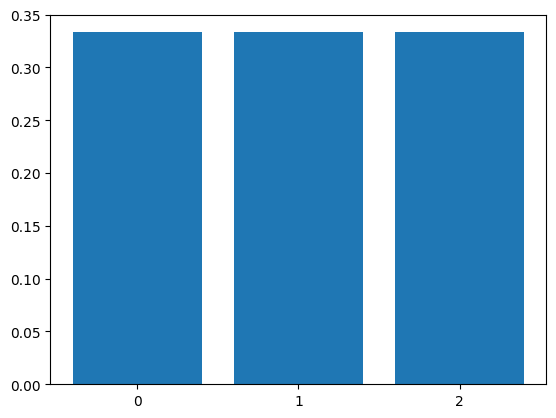

In [ ]:
ls_list = []
fig, ax = plt.subplots()
for batch_data in train_loader:
  ls = batch_data["lab"]
  for lab in ls:
    ls_list.append(lab)
classe_labels, counts = np.unique(ls_list, return_counts=True)
print(counts)
print(sum(counts))
proportion = counts[:]/sum(counts)
print(proportion)
ax.bar(classe_labels, proportion)
ax.set_xticks(classe_labels)
plt.show()

# encoder training

In [ ]:
from monai.networks.nets import DenseNet121, resnet34, resnet10
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Define the U-Net
        self.encoder = resnet34(
            spatial_dims=3,
            n_input_channels=1,
            num_classes=512,
            #layers=5,
            pretrained=False,#False,
            # no_max_pool=True, #是否使用 maxpool 層
            feed_forward=False #是否為輸出添加 FC 層
            )

        # self.down = nn.ReLU(nn.MaxPool1d(2))#relu insnorM
        # self.down = nn.ReLU(nn.MaxPool1d(nn.Conv1d(1, 1, 3, stride=2)))
        # self.fusion = nn.Conv1d(in_channels=1536, out_channels=1, kernel_size=1)
        # self.fusion = nn.AvgPool2d(3, stride=2)
        # self.transformer = nn.MultiheadAttention(512*3, 3)


        # self.fc = nn.Linear(in_features=512, out_features=3)
        self.fc = nn.Linear(in_features=1536, out_features=3)

    def forward(self, x1, x2, x3):
        # x1, x2, x3 = x.chunk(3, dim=1)
        # print("ori1 =",x1.shape) #[6, 1, 96, 96, 96]
        # print("ori2 =",x2.shape)
        # print("ori3 =",x3.shape)
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        z3 = self.encoder(x3)
        # print("encode1 =",z1.shape) #[6, 512] #[1, 256, 6, 6, 6]
        # print("encode2 =",z2.shape)
        # print("encode3 =",z3.shape)

        # z = z1+z2+z3
        # print("sum =", z.shape) #[6, 512]

        z = torch.cat((z1, z2, z3), dim=1)
        # print("concat =",z.shape) #[1,1536] #[1, 768, 6, 6, 6]

        y = self.fc(z)
        # print("fc =",y.shape) #[6, 3]

        return y

In [ ]:
import torch.optim as optim
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.losses import FocalLoss
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

model_name = "joint_concat"+str(fold)
model = MyModel().to(device)

# summary(model, (1,96,96,96))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
num_epochs = max_epochs
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=0, last_epoch=-1)
lrs = []
# loss_function = torch.nn.CrossEntropyLoss()

# start a typical PyTorch training
epoch_loss_values = []
epoch_acc_values = []
metric_values = []

# writer = SummaryWriter(log_dir=save_path+"log/"+model_name)
# log_dir = "logs"
writer = SummaryWriter(save_path+model_name)

ls_list = []
alpha = 1
gamma = 2


for epoch in range(num_epochs):
    model.train()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_loss = 0
    epoch_acc = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        PREimgs, Aimgs, PVimgs, ls = batch_data["PREimg"].to(device),batch_data["Aimg"].to(device),batch_data["PVimg"].to(device), batch_data["lab"].to(device)
        ls_list.append(ls)
        labels = torch.nn.functional.one_hot(ls, num_classes=num_classes).float()

        #梯度歸0
        optimizer.zero_grad()

        #模型預測
        outputs = model(PREimgs, Aimgs, PVimgs)
        # print(outputs)

        #計算loss
        ## Focal loss ##
        loss_function = FocalLoss(gamma=gamma, to_onehot_y=True)
        loss = loss_function(outputs, ls)

        #查看模型預測的結果
        _,predict_label = torch.max(outputs, 1)
        p_label = torch.nn.functional.one_hot(predict_label, num_classes=num_classes).float()

        #反向傳播後傳給optimizer
        loss.backward()
        optimizer.step()
        lr_sched.step() ##
        lrs.append(optimizer.param_groups[0]["lr"]) ##

        #計算當次epoch的loss值
        epoch_loss += loss.item()

        #計算當次epoch的acc
        # train_acc = torch.sum(p_label==labels)/len(p_label)
        # epoch_acc += train_acc.item()
        acc_value = torch.eq(outputs.argmax(dim=1), ls)
        acc_metric = acc_value.sum().item() / len(acc_value)
        epoch_acc += acc_metric

        epoch_len = len(train_ds) // BS## train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}, train_accuracy: {acc_metric:.4f}")
        # writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        # writer.add_scalar("train_accuracy", acc_metric, epoch_len * epoch + step) # epoch+1 ##

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    epoch_acc /= step
    epoch_acc_values.append(epoch_acc)
    print(f"epoch {epoch + 1} average acc: {epoch_acc:.4f}")

    writer.add_scalar("train_loss", epoch_loss, epoch + 1)
    writer.add_scalar("train_accuracy", epoch_acc, epoch + 1)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        ## model_CAM.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_PREimgs, val_Aimgs, val_PVimgs, val_ls = val_data["PREimg"].to(device),val_data["Aimg"].to(device),val_data["PVimg"].to(device), val_data["lab"].to(device)
            val_labels = torch.nn.functional.one_hot(val_ls, num_classes=num_classes).float()
            with torch.no_grad():
                val_outputs = model(val_PREimgs, val_Aimgs, val_PVimgs)
                value = torch.eq(val_outputs.argmax(dim=1), val_ls)
                metric_count += len(value)
                num_correct += value.sum().item()

                #計算loss
                val_loss = loss_function(val_outputs, val_ls)

                ## CAM_outputs = model_CAM(val_images)

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), save_path+model_name+"/"+model_name+".pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} val accuracy: {metric:.4f} ")
        print(f"Current epoch: {epoch+1} val loss: {val_loss.item():.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)
        writer.add_scalar("val_loss", val_loss, epoch + 1) ##

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/8, train_loss: 0.3018, train_accuracy: 0.3333
2/8, train_loss: 0.2957, train_accuracy: 0.3333
3/8, train_loss: 0.2726, train_accuracy: 0.3333
4/8, train_loss: 0.2617, train_accuracy: 0.3333
5/8, train_loss: 0.2521, train_accuracy: 0.3333
6/8, train_loss: 0.2588, train_accuracy: 0.3333
7/8, train_loss: 0.2449, train_accuracy: 0.3333
8/8, train_loss: 0.2126, train_accuracy: 0.3333
9/8, train_loss: 0.2013, train_accuracy: 0.3333
10/8, train_loss: 0.2043, train_accuracy: 0.3333
epoch 1 average loss: 0.2506
epoch 1 average acc: 0.3333
saved new best metric model
Current epoch: 1 val accuracy: 0.3846 
Current epoch: 1 val loss: 0.1253 
Best accuracy: 0.3846 at epoch 1
----------
epoch 2/100
1/8, train_loss: 0.2065, train_accuracy: 0.5000
2/8, train_loss: 0.1576, train_accuracy: 0.5000
3/8, train_loss: 0.1552, train_accuracy: 0.5000
4/8, train_loss: 0.1829, train_accuracy: 0.5000
5/8, train_loss: 0.1696, train_accuracy: 0.3333
6/8, train_loss: 0.1657, train_accuracy: 

## evaluation
https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

In [ ]:
model = MyModel().to(device)
# model_name = "TNM_encoder+FC"
# model.load_state_dict(torch.load(save_path+model_name+".pth"),False)
model.load_state_dict(torch.load(save_path+model_name+'/'+model_name+".pth"),False)
model.eval()

In [ ]:
!pip install seaborn

In [ ]:
label2class = { 'A':0, 'B':1, 'C':2 }
class2label = { 0:'A', 1:'B', 2:'C' }
# label2class = { 'A':0, 'B':1, 'C':2, 'D':3 }
# class2label = { 0:'A', 1:'B', 2:'C', 3:'D' }

In [ ]:
import seaborn as sns
outputs_all = pd.DataFrame()
import torch.nn as nn
a = nn.Softmax()

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
  # for i, (inputs, classes) in enumerate(test_loader):
  #   inputs = inputs.to(device)
  for test_data in test_loader:
    test_PREimgs, test_Aimgs, test_PVimgs, test_ls = test_data["PREimg"].to(device),test_data["Aimg"].to(device),test_data["PVimg"].to(device), test_data["lab"].to(device)
    test_labels = torch.nn.functional.one_hot(test_ls, num_classes=num_classes).float()
    classes = test_labels.to(device)
    classes = classes.argmax(-1)
    outputs = model(test_PREimgs, test_Aimgs, test_PVimgs)
    outputs = a(outputs)
    outputs_np = outputs.cpu().data.numpy()
    outputs_df = pd.DataFrame(outputs_np)
    outputs_all = pd.concat([outputs_all, outputs_df], ignore_index = True)

    _, preds = torch.max(outputs, 1)

    for t, p in zip(classes.view(-1), preds.view(-1)):
      confusion_matrix[t.long(), p.long()] += 1

  print(outputs_all)
  outputs_all.to_csv(save_path+model_name+"/"+model_name+".csv", encoding='utf-8', index=False)

In [ ]:
plt.figure(figsize=(6,5))

class_names = list(class2label.values()) #label2class
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
print(df_cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig(save_path+model_name+"/"+model_name+'.png')

In [ ]:
print(df_cm.sum(axis=1))
all = np.sum(df_cm.sum(axis=1))
correct = df_cm['A']['A'] + df_cm['B']['B'] + df_cm['C']['C']
acc = (correct/all)
print(acc)

## TensorBoard

In [ ]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir=save_path+model_name